In [15]:
from osgeo import gdal
import numpy as np
import rasterio
import geopandas as gpd
from rasterio.features import rasterize

# Assuming the required functions (read_dem_gdal, calculate_slope_gdal, process_forest_tiff, read_raster_data) are defined elsewhere

def identify_pra_with_ruggedness_and_windshelter(slope, ruggedness, wind_shelter, non_forest_mask, slope_range, ruggedness_threshold, wind_shelter_threshold):
    """
    Identifies potential avalanche release areas based on slope, ruggedness, wind shelter criteria, and exclusion of forest areas.

    Parameters:
    - slope: numpy array, the slope data in degrees.
    - ruggedness: numpy array, the ruggedness data.
    - wind_shelter: numpy array, the wind shelter data.
    - non_forest_mask: numpy array, a binary mask indicating non-forest (1) and forest (0) areas.
    - slope_range: tuple, the minimum and maximum slope in degrees for PRA.
    - ruggedness_threshold: int, the maximum ruggedness value for PRA.
    - wind_shelter_threshold: float, the threshold for wind shelter value to be considered for PRA.

    Returns:
    - pra_mask: numpy array, a binary mask indicating potential avalanche release areas excluding forest regions.
    """
    # Apply criteria
    slope_criteria = (slope >= slope_range[0]) & (slope <= slope_range[1])
    ruggedness_criteria = ruggedness <= ruggedness_threshold
    wind_shelter_criteria = wind_shelter >= wind_shelter_threshold
    
    # Combine criteria and exclude forest areas
    pra_mask = slope_criteria & ruggedness_criteria & wind_shelter_criteria & non_forest_mask

    return pra_mask.astype(np.uint8)

def rasterize_shapefile_to_match_dem(shapefile_path, dem_path):
    gdf = gpd.read_file(shapefile_path)
    with rasterio.open(dem_path) as dem:
        meta = dem.meta.copy()
        meta.update(compress='lzw', dtype=rasterio.uint8, count=1)
        shapes = ((geom, 1) for geom in gdf.geometry)
        with rasterio.MemoryFile() as memfile:
            with memfile.open(**meta) as temp_dataset:
                temp_dataset.write_band(1, rasterize(shapes=shapes, fill=0, out_shape=dem.shape, transform=dem.transform, all_touched=True))
                result_array = temp_dataset.read(1)
    return result_array

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union else 0


import rasterio
from rasterio.enums import Resampling

def resample_raster_to_match(source_raster_path, target_raster_path, resampled_raster_path):
    with rasterio.open(target_raster_path) as target_ds:
        target_transform = target_ds.transform
        target_width = target_ds.width
        target_height = target_ds.height

    with rasterio.open(source_raster_path) as src_ds:
        # Resample source raster to match target
        data = src_ds.read(
            out_shape=(src_ds.count, target_height, target_width),
            resampling=Resampling.bilinear
        )

        # Copy and update the metadata from the source raster for writing the output
        out_meta = src_ds.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": target_height,
            "width": target_width,
            "transform": target_transform
        })

        with rasterio.open(resampled_raster_path, "w", **out_meta) as dest_ds:
            dest_ds.write(data)

# Define file paths
dem_path = "D:/Bachelerarbeit/Daten/Gis_Daten/Passeiertal DGM/DGM_2_5_Burggrafenamt.tif"
shapefile_path = "D:/Bachelerarbeit/Daten/Gis_Daten/PRA/PRA_30yFor.shp"
forest_path = "D:/Bachelerarbeit/Daten/Gis_Daten/Wald_Suedtirol/ForestSuedtirol.tif"

# Load necessary data
slope_array = calculate_slope_gdal(dem_path)  # Or use your custom function
non_forest_mask = process_forest_tiff(forest_path, dem_path)  # Or use your custom function
reference_pra_mask = rasterize_shapefile_to_match_dem(shapefile_path, dem_path)

ruggedness_ranges = range(6, 13)  # Example range for ruggedness thresholds
wind_shelter_ranges = np.arange(-0.2, 0.3, 0.1)  # Example range for wind shelter thresholds
slope_ranges = [(28, 50), (30, 60)]  # Exam

# Load other necessary data only once
ruggedness = read_raster_data("D:/Bachelerarbeit/Daten/Gis_Daten/PRA_PF/roughness.tif")
wind_shelter = read_raster_data("D:/Bachelerarbeit/Daten/Gis_Daten/PRA_PF/Windshelter_180.tif")

pad_height = slope_array.shape[0] - ruggedness.shape[0]
pad_width = slope_array.shape[1] - ruggedness.shape[1]

# Apply padding equally on all sides; adjust if you want to pad differently
ruggedness_padded = np.pad(ruggedness, ((pad_height//2, pad_height - pad_height//2), 
                                         (pad_width//2, pad_width - pad_width//2)), 
                            mode='constant', constant_values=0)

wind_shelter_padded = np.pad(wind_shelter, ((pad_height//2, pad_height - pad_height//2), 
                                            (pad_width//2, pad_width - pad_width//2)), 
                             mode='constant', constant_values=0)

print("Slope array shape:", slope_array.shape)
print("Ruggedness array shape:", ruggedness_padded.shape)
print("Wind shelter array shape:", wind_shelter_padded.shape)
print("Non-forest mask shape:", non_forest_mask.shape)


ious_28_50 = np.zeros((len(ruggedness_ranges), len(wind_shelter_ranges)))
ious_30_60 = np.zeros((len(ruggedness_ranges), len(wind_shelter_ranges)))
ious_28_60 = np.zeros((len(ruggedness_ranges), len(wind_shelter_ranges)))

# Assuming ruggedness_ranges and wind_shelter_ranges are properly defined lists or arrays
for slope_range, ious_array in [((28, 50), ious_28_50), ((30, 60), ious_30_60), ((28, 60), ious_28_60)]:
    for i, ruggedness_threshold in enumerate(ruggedness_ranges):
        for j, wind_shelter_threshold in enumerate(wind_shelter_ranges):
            pra_mask = identify_pra_with_ruggedness_and_windshelter(
                slope=slope_array,
                ruggedness=ruggedness_padded,
                wind_shelter=wind_shelter_padded,
                non_forest_mask=non_forest_mask,
                slope_range=slope_range,
                ruggedness_threshold=ruggedness_threshold,
                wind_shelter_threshold=wind_shelter_threshold
            )
            
            # Calculate the IoU between the generated PRA mask and the reference PRA mask
            iou = calculate_iou(pra_mask, reference_pra_mask)
            
            # Store the IoU value in the appropriate array
            ious_array[i, j] = iou
            
            # Print or log the IoU and the thresholds used for this iteration
            print(f"Ruggedness Threshold: {ruggedness_threshold}, Wind Shelter Threshold: {wind_shelter_threshold:.1f}, "
                  f"Slope Range: {slope_range[0]}-{slope_range[1]}, IoU with Reference: {iou:.3f}")



slope errechnet
Wald Tiff geladen
Slope array shape: (22862, 18243)
Ruggedness array shape: (22862, 18243)
Wind shelter array shape: (22862, 18243)
Non-forest mask shape: (22862, 18243)
Ruggedness Threshold: 6, Wind Shelter Threshold: -0.2, Slope Range: 28-50, IoU with Reference: 0.473
Ruggedness Threshold: 6, Wind Shelter Threshold: -0.1, Slope Range: 28-50, IoU with Reference: 0.474
Ruggedness Threshold: 6, Wind Shelter Threshold: 0.0, Slope Range: 28-50, IoU with Reference: 0.474
Ruggedness Threshold: 6, Wind Shelter Threshold: 0.1, Slope Range: 28-50, IoU with Reference: 0.476
Ruggedness Threshold: 6, Wind Shelter Threshold: 0.2, Slope Range: 28-50, IoU with Reference: 0.479
Ruggedness Threshold: 7, Wind Shelter Threshold: -0.2, Slope Range: 28-50, IoU with Reference: 0.552
Ruggedness Threshold: 7, Wind Shelter Threshold: -0.1, Slope Range: 28-50, IoU with Reference: 0.552
Ruggedness Threshold: 7, Wind Shelter Threshold: 0.0, Slope Range: 28-50, IoU with Reference: 0.553
Ruggedness

C:\Users\franz\AppData\Local\ESRI\conda\envs\my_env\lib\site-packages\osgeo\gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [4]:
import rasterio
from rasterio.features import shapes
from scipy.ndimage import binary_closing
import geopandas as gpd
from shapely.geometry import shape, Polygon
from shapely.ops import unary_union
import numpy as np

# Open the raster file
with rasterio.open('D:\\Bachelerarbeit\\Daten\\Gis_Daten\\PRA_PF\\pra_mask.tif') as src:
    raster_data = src.read(1)
    transform = src.transform

# Apply a morphological closing operation to fill small holes and connect nearby regions
closed_raster = binary_closing(raster_data == 1, structure=np.ones((5,5))).astype(np.uint8)

# Vectorize the morphologically processed raster
vectorized_features = shapes(closed_raster, transform=transform)
geometries = [shape(geometry) for geometry, value in vectorized_features if value == 1]

# Combine adjacent polygons to create larger shapes
combined_polygons = unary_union([Polygon(g) for g in geometries])

# Simplify the combined polygon geometries to generalize the shapes
simplified_polygons = combined_polygons.simplify(10.0, preserve_topology=False)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame({'geometry': [simplified_polygons]}, crs=src.crs)

# Save the GeoDataFrame to a new shapefile
gdf.to_file('D:\\Bachelerarbeit\\Daten\\Gis_Daten\\PRA_PF\\pra_mask_shp_.shp')


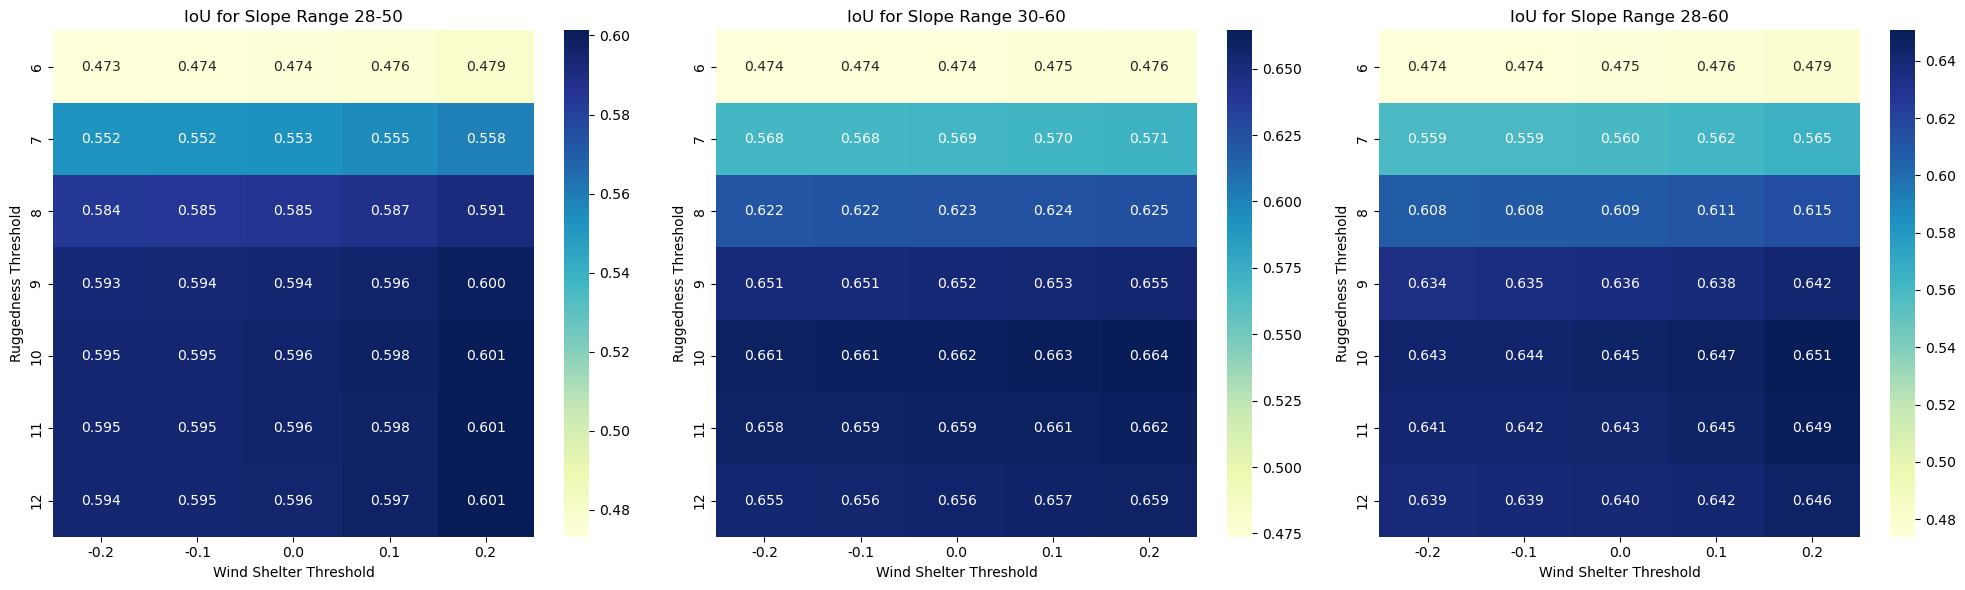

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming ious_28_50, ious_30_60, and ious_28_60 are filled with the correct IoU values
slope_ranges_titles = ['28-50', '30-60', '28-60']
ious_arrays = [ious_28_50, ious_30_60, ious_28_60]

# Set up the matplotlib figure with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Plot each heatmap
for ax, ious, title in zip(axs, ious_arrays, slope_ranges_titles):
    sns.heatmap(ious, ax=ax, xticklabels=np.round(wind_shelter_ranges, 1), yticklabels=ruggedness_ranges, annot=True, fmt=".3f", cmap="YlGnBu")
    ax.set_title(f'IoU for Slope Range {title}')
    ax.set_xlabel("Wind Shelter Threshold")
    ax.set_ylabel("Ruggedness Threshold")

plt.tight_layout()
plt.show()

# Optionally, save the figure to a file
fig.savefig("slope_ranges_heatmaps.png", dpi=300)

